In [1]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        shots = [x for x in events if x['type']['name'] == "Shot"]
                
        for s in shots:
            attributes = {
                "x": s['location'][0],
                "y": s['location'][1],
                "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
                "phase": s['shot']['type']['name'],
                "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
                "statsbomb_xg": s['shot']['statsbomb_xg']
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [4]:

competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


In [24]:
df

,x,y,head,phase,outcome,statsbomb_xg,distance,angle
0,100.625,28.90,0,Open Play,1,0.074087,6.719421,49.375584
1,98.000,30.60,0,Open Play,1,0.292995,7.782031,25.906508
2,88.375,46.75,0,Free Kick,0,0.078714,20.951208,37.485222
3,90.125,20.40,0,Open Play,0,0.028038,20.155040,42.436230
4,84.000,31.45,0,Open Play,0,0.064261,21.154255,6.923449
...,...,...,...,...,...,...,...,...
1701,81.375,22.95,0,Free Kick,0,0.060391,26.081471,25.066661
1702,92.750,51.00,0,Open Play,0,0.027727,20.953818,54.223922
1703,81.375,36.55,0,Open Play,0,0.020467,23.762221,6.160457
1704,84.000,28.90,0,Free Kick,0,0.088615,21.610414,13.650419


In [6]:
df.x = df.x / 120 * 105
df.y = df.y / 80 * 68

In [14]:
df['distance'] = np.sqrt((df.x - 105)**2 + (df.y - 34)**2)

In [23]:
df['angle'] = np.abs(np.arcsin((df.y - 34) / df.distance) * 180 / np.pi)

In [25]:
shots = df[~df['phase'].isin(['Free Kick', 'Penalty'])]

In [26]:
shots

,x,y,head,phase,outcome,statsbomb_xg,distance,angle
0,100.625,28.90,0,Open Play,1,0.074087,6.719421,49.375584
1,98.000,30.60,0,Open Play,1,0.292995,7.782031,25.906508
3,90.125,20.40,0,Open Play,0,0.028038,20.155040,42.436230
4,84.000,31.45,0,Open Play,0,0.064261,21.154255,6.923449
5,97.125,42.50,0,Open Play,0,0.303150,11.587304,47.185801
...,...,...,...,...,...,...,...,...
1699,98.000,34.00,1,Open Play,0,0.055357,7.000000,0.000000
1700,92.750,34.00,1,Open Play,0,0.016941,12.250000,0.000000
1702,92.750,51.00,0,Open Play,0,0.027727,20.953818,54.223922
1703,81.375,36.55,0,Open Play,0,0.020467,23.762221,6.160457


In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(shots[['distance', 'angle']], shots.outcome)

LogisticRegression()

In [29]:
model.coef_

array([[-0.14512553, -0.00459135]])

In [30]:
model.intercept_

array([-0.3179833])

In [32]:
predictions = model.predict_proba(shots[['distance', 'angle']])[:, 1]

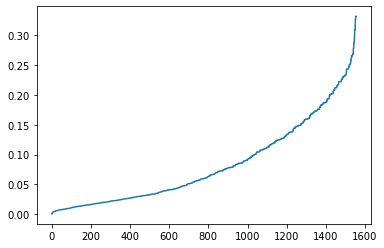

In [34]:
plt.plot(sorted(predictions))

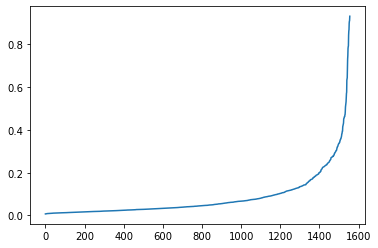

In [35]:
plt.plot(sorted(shots.statsbomb_xg))

In [38]:
sorted(predictions, reverse=True)

[0.33229609992566334,
 0.3322960999256629,
 0.3320477684564724,
 0.32755334433484284,
 0.32755334433484257,
 0.309856112294953,
 0.309856112294953,
 0.309856112294953,
 0.30450789138188594,
 0.29424504840638105,
 0.28836032160535785,
 0.28836032160535774,
 0.28434051691488166,
 0.27830047578258765,
 0.27830047578258765,
 0.2686240720139149,
 0.2686240720139149,
 0.2686240720139149,
 0.2686240720139149,
 0.2659516156390594,
 0.2659516156390593,
 0.2659516156390593,
 0.2659516156390593,
 0.2659516156390593,
 0.26201930470032453,
 0.26201930470032453,
 0.258861958707041,
 0.258861958707041,
 0.25352639026987284,
 0.25352639026987284,
 0.25352639026987284,
 0.25036776003754213,
 0.25036776003754213,
 0.25036776003754213,
 0.25036776003754213,
 0.25036776003754213,
 0.24748431903322815,
 0.24748431903322815,
 0.24748431903322815,
 0.2437850459248583,
 0.2437850459248583,
 0.2437850459248583,
 0.2437850459248583,
 0.2437850459248583,
 0.2437850459248583,
 0.24378504592485825,
 0.243785045924